In [50]:
import os
from dotenv import load_dotenv
from numpy import vectorize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
import string

s=""
sample_files = []
load_dotenv()

Space_Cleared_Exts = os.environ["EXTENSIONS"].replace(" ", "")
# ------------------------------------------------------------------
# Parcourt tout les fichiers finissant avec les extensions dans .env
# ------------------------------------------------------------------
for ext in os.environ["EXTENSIONS"] :
    if(ext==",") :
        ext="["
        for doc in os.listdir("./FilesToTest/") :
            if doc.endswith(str(s)) :
                sample_files.append(''.join(doc))
        s = ""
    if(ext!="[" and ext!="]") :
        s+=ext
for doc in os.listdir("./FilesToTest/") :
    if doc.endswith(str(s.replace(" ",""))) :
        sample_files.append(''.join(doc))
 
sample_contents = [open("./FilesToTest/"+File).read() for File in sample_files]
print(sample_contents)

['var x = math.floor(math.random() * 5);\nbeed = 2\n\nvar kek = "kek";\n\nif(x==1) {\n    b = 3\n} else {\n    b = 1\n}\n\n\n// DDDDDDDDDDDDdd\n/* HEHEBOY \n\n\n\nSDqsd\n*/', 'Content3\nbeed = 5\n// Normal Commentary', 'yes\n// Normal Commentary', 'HEHE']


In [51]:
Commentary_Content = []
Var_Content = []
Equal_Content = []
Loop_Content = []

Sample_Content_Double = []
Sample_Content_Without_VarComms = []
Sample_Content_Without_VarCommsLoop =  []
Sample_Content_Without_VarCommsLoopEq = []

# ---------------------------------------------------------------------------------
# Parcourt notre texte et enleve les commentaires si le texte vient d'un fichier JS
# ---------------------------------------------------------------------------------

def PurgeJSCommentary(word) :
    Sample_ContentsBis = sample_contents[word].splitlines(True)
    Sample_Content_SubFile = []
    Commentary_SubFile = []
    Long_Comment = False
    for lines in Sample_ContentsBis :
        if(Long_Comment) :
            Commentary_SubFile.append(lines)
        if("//" in lines) :
            Commentary_SubFile.append(lines)
        if("/*" in lines):
            Long_Comment = True
            Commentary_SubFile.append(lines)
        if("*/" in lines):
            Long_Comment = False
            Commentary_SubFile.append(lines) 
        if("//" not in lines and "/*" not in lines and "*/" not in lines and Long_Comment == False):
            Sample_Content_SubFile.append(lines)
    Sample_Content_Double.append(Sample_Content_SubFile)
    Commentary_Content.append(Commentary_SubFile)

In [52]:
def PurgeJSVariables(index) :
    Sample_Content_SubFile = []
    Var_SubFile = []
    for lines in Sample_Content_Double[index] :
        if("var" in lines) :
            Var_SubFile.append(lines)
        else :
            Sample_Content_SubFile.append(lines)
    Sample_Content_Without_VarComms.append(Sample_Content_SubFile)
    Var_Content.append(Var_SubFile)

In [53]:
def PurgeJSLoops(index) :
    Sample_Content_SubFile = []
    Loop_SubFile = []
    IsLoop = False
    for lines in Sample_Content_Without_VarComms[index] :
        if("}" in lines) :
            Loop_SubFile.append(lines)
            IsLoop = False
        if(IsLoop) :
            Loop_SubFile.append(lines)
        if("{" in lines) :
            Loop_SubFile.append(lines)
            IsLoop = True
        if("}" not in lines and "{" not in lines and IsLoop is False) :
            Sample_Content_SubFile.append(lines)
    Sample_Content_Without_VarCommsLoop.append(Sample_Content_SubFile)
    Loop_Content.append(Loop_SubFile)

In [54]:
def PurgeJSEquals(index) :
    Sample_Content_SubFile =[]
    Equal_SubFile = []
    for lines in Sample_Content_Without_VarCommsLoop[index] :
        if("=" in lines) :
            Equal_SubFile.append(lines)
        else :
            Sample_Content_SubFile.append(lines)
    Sample_Content_Without_VarCommsLoopEq.append(Sample_Content_SubFile)
    Equal_Content.append(Equal_SubFile)

In [55]:
    for i in range(len(sample_files)) :
        if(sample_files[i].endswith(".js")) :
            PurgeJSCommentary(i)
            PurgeJSVariables(i)
            PurgeJSLoops(i)
            PurgeJSEquals(i)

In [56]:
All_Content = []


print("Commentary Content : \n")
print(Commentary_Content)
print("\nVar Content : \n")
print(Var_Content)
print("\nLoop Content : \n")
print(Loop_Content)
print("\nEqual Content : \n")
print(Equal_Content)

All_Content.append(Commentary_Content)
All_Content.append(Var_Content)
All_Content.append(Loop_Content)
All_Content.append(Equal_Content)


Commentary Content : 

[['// DDDDDDDDDDDDdd\n', '/* HEHEBOY \n', '\n', '\n', '\n', 'SDqsd\n', '*/', '*/'], ['// Normal Commentary'], ['// Normal Commentary']]

Var Content : 

[['var x = math.floor(math.random() * 5);\n', 'var kek = "kek";\n'], [], []]

Loop Content : 

[['if(x==1) {\n', '    b = 3\n', '} else {\n', '} else {\n', '    b = 1\n', '}\n'], [], []]

Equal Content : 

[['beed = 2\n'], ['beed = 5\n'], []]


In [57]:
def tokenize() :
    return ""
tokenize()

''

In [58]:
# vectorize = lambda Text: TfidfVectorizer().fit_transform(Text).toarray()

def vectorize(Text) :
    return TfidfVectorizer().fit_transform(Text).toarray()

# similarity = lambda doc1, doc2: cosine_similarity([doc1, doc2])

def similarity(doc1,doc2) :
    return cosine_similarity([doc1,doc2])

In [59]:

def check_plagiarism(TestFiles):
    vectors = vectorize(TestFiles)
    s_vectors = list(zip(sample_files, vectors))
    results = set()
    for sample_a, text_vector_a in s_vectors:
        new_vectors = s_vectors.copy()
        current_index = new_vectors.index((sample_a, text_vector_a))
        del new_vectors[current_index]
        for sample_b, text_vector_b in new_vectors:
            sim_score = similarity(text_vector_a, text_vector_b)[0][1]
            sample_pair = sorted((sample_a, sample_b))
            score = sample_pair[0], sample_pair[1], sim_score
            results.add(score)
    return results

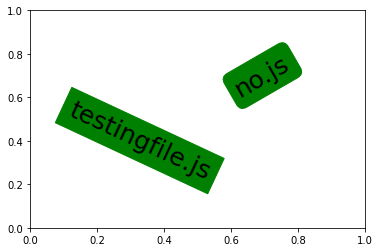

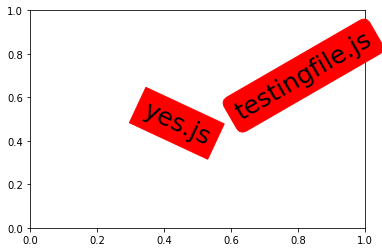

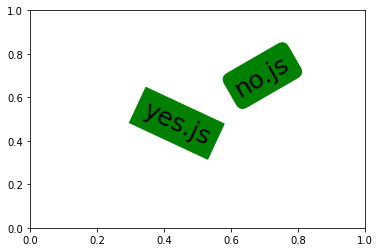

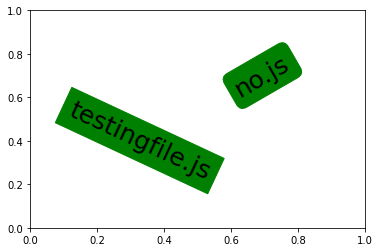

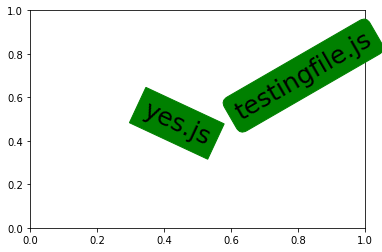

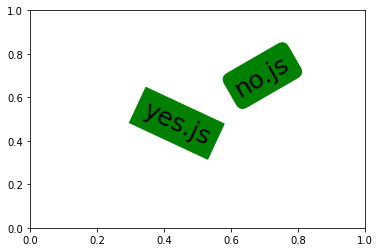

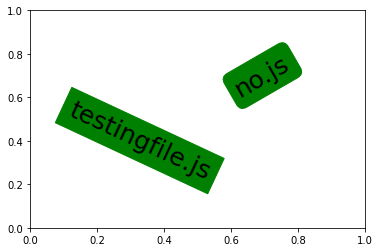

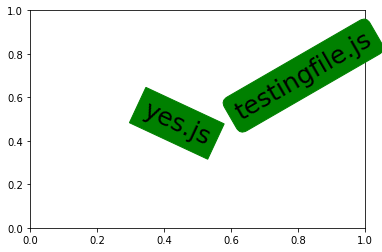

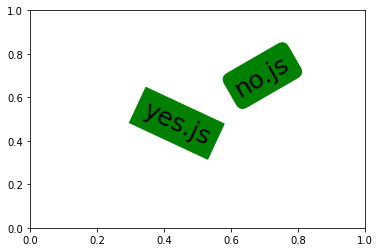

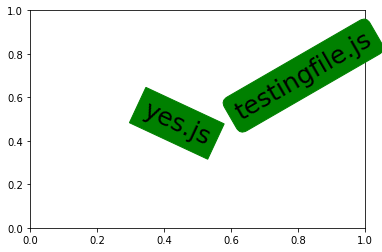

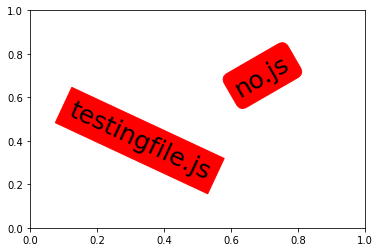

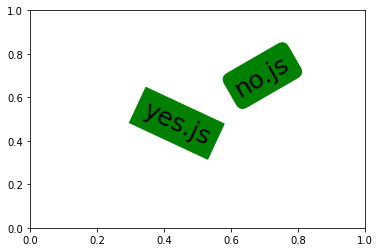

In [62]:

import matplotlib.pyplot as plt

def ExecutePlagiarismChecker(ArrayToTest):
    for array_index in range(len(ArrayToTest)):
        temp_text = ""
        for item_index in range(len(ArrayToTest[array_index])):
            temp_text += ArrayToTest[array_index][item_index]
        ArrayToTest[array_index] = temp_text
    return check_plagiarism(ArrayToTest)

for Content in All_Content :   
    for score in ExecutePlagiarismChecker(Content) :
       
        result = (','.join(map(str,(score)))).split(',')
        color = 'none'
        
        if(float(result[2])>0.6) :
            color='red'
            print(score)
        else :
            color='green'
            
        plt.text(0.6, 0.7, result[0], size=25, rotation=30.,
                ha="left", va="center",
                bbox=dict(boxstyle="round",
                        ec=(color),
                        fc=(color),
                        )
                )

        plt.text(0.55, 0.6, result[1], size=25, rotation=-25.,
                ha="right", va="top",
                bbox=dict(boxstyle="square",
                        ec=(color),
                        fc=(color),
                        )
                )

        plt.show()